In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import os
import math

***Pre-Processing the dataset***

In [2]:
'''Pulling the photos from folders with their paths'''

path_cats = []
train_path_cats = "../input/cat-and-dog/training_set/training_set/cats/"
for path in os.listdir(train_path_cats):
    if '.jpg' in path:
        path_cats.append(os.path.join(train_path_cats, path))
path_dogs = []
train_path_dogs = "../input/cat-and-dog/training_set/training_set/dogs/"
for path in os.listdir(train_path_dogs):
    if '.jpg' in path:
        path_dogs.append(os.path.join(train_path_dogs, path))
len(path_dogs), len(path_cats)

(4005, 4000)

In [3]:
'''Load training set'''

'''total pics in training set =  8005
    training_set = 6000 --- first 3000 of dogs and rest of cats
    validation_set = 2000 --- first 1000 of dogs and rest of cats'''

train_set_orig = np.zeros((6000, 64, 64, 3), dtype='float32')
for i in range(6000):
    if i < 3000:
        image = Image.open(path_dogs[i])
        img_resized = image.resize((64,64))
        train_set_orig[i] = np.asarray(img_resized)
    else:
        image = Image.open(path_cats[i - 3000])
        img_resized = image.resize((64,64))
        train_set_orig[i] = np.asarray(img_resized)

In [4]:
'''Load validation set'''

val_set_orig = np.zeros((2000, 64, 64, 3), dtype='float32')
for i in range(2000):
    if i < 1000:
        image = Image.open(path_dogs[i + 3000])
        img_resized = image.resize((64,64))
        val_set_orig[i] = np.asarray(img_resized)
    else:
        image = Image.open(path_cats[i + 2000])
        img_resized = image.resize((64,64))
        val_set_orig[i] = np.asarray(img_resized)

In [5]:
'''Labelling the training and validation set'''

y_train_ = np.zeros((3000, 1))
y_train_ = np.concatenate((y_train_, np.ones((3000, 1))))
y_val = np.zeros((1000, 1))
y_val = np.concatenate((y_val, np.ones((1000, 1))))
print("Training set labels" +str(y_train_.shape)+ "  validation set labels" + str(y_val.shape))

Training set labels(6000, 1)  validation set labels(2000, 1)


In [6]:
'''Suffling training set pics'''

r = np.arange(train_set_orig.shape[0])
np.random.shuffle(r)
train_set_x_orig = train_set_orig[r, :]
y_train = y_train_[r, :]

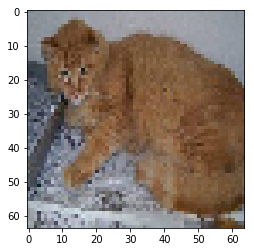

[1.]


In [7]:
'''Example of a image'''

index = 0
plt.imshow(np.uint8(train_set_x_orig[index]), interpolation='nearest')
plt.show()
print(y_train[index])

***Summary of Processed data***

In [8]:
m_train = train_set_x_orig.shape[0]
m_val = val_set_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of validation examples: m_val = " + str(m_val))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(y_train.shape))
print ("val_set_x shape: " + str(val_set_orig.shape))
print ("val_set_y shape: " + str(y_val.shape))

Number of training examples: m_train = 6000
Number of validation examples: m_val = 2000
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (6000, 64, 64, 3)
train_set_y shape: (6000, 1)
val_set_x shape: (2000, 64, 64, 3)
val_set_y shape: (2000, 1)


***Flattening the training and validation arrays***

In [9]:
'''Reshape the training and validation examples'''

x_train = train_set_x_orig.reshape(6000,-1)
x_val = val_set_orig.reshape(2000,-1)

print ("train_set_x_flatten shape: " + str(x_train.shape))
print ("train_set_y shape: " + str(y_train.shape))
print ("val_set_x_flatten shape: " + str(x_val.shape))
print ("val_set_y shape: " + str(y_val.shape))

train_set_x_flatten shape: (6000, 12288)
train_set_y shape: (6000, 1)
val_set_x_flatten shape: (2000, 12288)
val_set_y shape: (2000, 1)


***Model for Cat/Dog Classification with neural network mindset***

In [10]:
'''Standardizing dataset'''

x_train = x_train /255
x_val = x_val/255

In [11]:
def sigmoid(z):
    
    '''Compute the sigmoid of z
    Arguments:
    z -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(z)'''
    
    s = 1/(1 + np.exp(-z))
    return s

In [12]:
def initialize_with_zeros(dim):
    
    '''This function creates a vector of zeros of shape (dim, 1) for w and initializes b t
    o 0.
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)'''
    
    w = np.zeros((dim, 1))
    b = 0
    return w, b

In [13]:
def random_mini_batches(X, Y, mini_batch_size, seed = 0):
    
    '''Creates a list of random minibatches from (X, Y)
    Arguments:
    X -- input data, of shape (number of examples, input size)
    Y -- true "label" vector (1 for cat / 0 for dog), of shape (number of examples, 1)
    mini_batch_size -- size of the mini-batches, integer
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)'''
    
    np.random.seed(seed)            
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Shuffle (X, Y)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]

    # Partition (shuffled_X, shuffled_Y). Minus the end case.
    
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k*mini_batch_size:(k+1)*mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k*mini_batch_size:(k+1)*mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[mini_batch_size * num_complete_minibatches::, :]
        mini_batch_Y = shuffled_Y[mini_batch_size * num_complete_minibatches::, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [14]:
def propagate(w, b, X, Y):
    
    '''Implement the cost function and its gradient for the propagation explained above
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if dog, 1 if cat) of size (number of examples, 1)
    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b'''
    
    m = X.shape[0]
    
    '''FORWARD PROPAGATION (FROM X TO COST)'''

    A = (sigmoid(np.dot(w.T, X.T) + b)).T
    cost = -(np.sum(Y*np.log(A) + (1 - Y)*np.log(1 - A)))/m
    
    '''BACKWARD PROPAGATION (TO FIND GRAD)'''

    dw = np.dot(X.T, (A-Y))/m
    db = np.sum(A-Y)/m
    
    cost = np.squeeze(cost)
    grads = {"dw": dw,
             "db": db}
    return grads, cost

In [15]:
def optimize(w, b, X, Y, num_epochs, learning_rate, mini_batch_size, print_cost = False):
    
    '''This function optimizes w and b by running a mini-batch gradient descent algorithm
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if dog, 1 if cat), of shape (number of examples, 1)
    num_epochs -- number of epochs of the optimization loop
    mini_batch_size --- number of training examples in one batch
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 10 steps
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of the costs computed during the optimization, this will be used to plot the learning curve.'''
    seed = 0
    costs = []
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        m = len(minibatches)
        cost_total = 0                                                # total cost for one epoch
        
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            grads, cost = propagate(w, b, minibatch_X, minibatch_Y)
            cost_total = cost_total + cost
            dw = grads["dw"]
            db = grads["db"]
            w = w - learning_rate*dw
            b = b - learning_rate*db
        cost_avg = cost_total / m                                    # average cost for one epoch
        if i % 10 == 0:
            costs.append(cost_avg)
        if print_cost and i % 10 == 0:
            print ("Cost after epochs %i: %f" %(i, cost_avg))
    params = {"w": w,
              "b": b}
    grads = {"dw": dw,
             "db": db}
    return params,grads, costs

In [16]:
def predict(w, b, X):
    
    '''Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (number of examples, num_px * num_px * 3)
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X'''
    
    m = X.shape[0]
    Y_prediction = np.zeros((m,1))
    w = w.reshape(X.shape[1], 1)
    A = sigmoid(np.dot(w.T,X.T) + b)
    for i in range(A.shape[1]):
        if A[0, i]>=0.5:
            Y_prediction[i, 0] = 1
        else:
            Y_prediction[i, 0] = 0
    return Y_prediction

In [17]:
def model(X_train, Y_train, X_val, Y_val, num_epochs = 100, learning_rate = 0.0006, mini_batch_size = 32, print_cost = False ):
    
    '''Builds the logistic regression model by calling the function you've implemented previously
    Arguments:
    X_train -- training set represented by a numpy array of shape ( m_train, num_px * num_px * 3)
    Y_train -- training labels represented by a numpy array (vector) of shape (m_train, 1)
    X_val -- test set represented by a numpy array of shape (m_test, num_px * num_px * 3)
    Y_val -- test labels represented by a numpy array (vector) of shape (m_test, 1)
    num_epochs -- number of epochs of the optimization loop
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    mini_batch_size --- number of training examples in one batch
    print_cost -- Set to true to print the cost every 10 iterations
    Returns:
    d -- dictionary containing information about the model.'''
    
    w, b = initialize_with_zeros(np.size(X_train,1))
    
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_epochs, learning_rate, mini_batch_size, print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_val = predict(w, b, X_val)
    Y_prediction_train = predict(w, b, X_train)
    
    print("train set accuracy for model: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("validation set accuracy for model: {} %".format(100 - np.mean(np.abs(Y_prediction_val - Y_val)) * 100))
    d = {"costs": costs,
         "Y_prediction_val": Y_prediction_val,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_epochs": num_epochs}
    return d

In [18]:
d = model(x_train, y_train, x_val, y_val, num_epochs = 200, learning_rate = 0.0006, mini_batch_size = 32, print_cost = True)

Cost after epochs 0: 0.690514
Cost after epochs 10: 0.657914
Cost after epochs 20: 0.644221
Cost after epochs 30: 0.637143
Cost after epochs 40: 0.628446
Cost after epochs 50: 0.621274
Cost after epochs 60: 0.616775
Cost after epochs 70: 0.610563
Cost after epochs 80: 0.604731
Cost after epochs 90: 0.599270
Cost after epochs 100: 0.596098
Cost after epochs 110: 0.590716
Cost after epochs 120: 0.586861
Cost after epochs 130: 0.584356
Cost after epochs 140: 0.579601
Cost after epochs 150: 0.575131
Cost after epochs 160: 0.573787
Cost after epochs 170: 0.569581
Cost after epochs 180: 0.566923
Cost after epochs 190: 0.563898
train set accuracy for model: 73.16666666666667 %
validation set accuracy for model: 58.15 %


***Learning Curve***

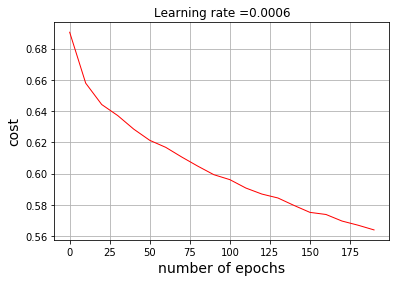

In [19]:
plt.plot(range(0, 200, 10), d["costs"], c="r", linewidth=1)
plt.xlabel("number of epochs", fontsize=14)
plt.ylabel("cost", fontsize=14)
plt.title("Learning rate =" + str(0.0006))
plt.grid()

***Sklearn Logistic Regression Model***

In [20]:
'''Reshaping the label vectors, to be used for sklearn logistic regression library'''

y_val_ = np.reshape(y_val, (y_val.shape[0], )).reshape(-1) 
y_train_ = np.reshape(y_train, (y_train.shape[0], )).reshape(-1)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear')
LR.fit(x_train,y_train_)
print("train set accuracy using Sklearn: {} %".format(LR.score(x_train, y_train_.T)*100))
print("validation set accuracy using Sklearn: {} %".format(LR.score(x_val, y_val_.T)*100))

train set accuracy using Sklearn: 79.65 %
validation set accuracy using Sklearn: 56.95 %
